In [1]:
import matplotlib as pyplot
import numpy as np
import pandas as pd
# import xgboost as xgb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

/home/23809/anaconda3/envs/mlb/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_pickle('data/games_with_odds.pkl')

In [3]:
df['date'] = pd.to_datetime(df['date'])
df['season'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday
df = df.sort_values(['team_code', 'date'])
df[['batting_r', 'other_team_runs']] = df[['batting_r', 'other_team_runs']].astype(int)

In [4]:
df['game_as_favorite'] = ((df['us_line'] < 0) ).astype(int)
df['game_as_underdog'] = ((df['us_line'] >= 0)).astype(int)
df['win_as_favorite'] = ((df['us_line'] < 0) & (df['batting_r'] > df['other_team_runs'])).astype(int)
df['win_as_underdog'] = ((df['us_line'] >= 0) & (df['batting_r'] > df['other_team_runs'])).astype(int)

In [5]:
game_cols = ['gid', 'status_ind', 'date', 'weekday', 'clouds', 'hp_ump', 'temp', 'wind_dir', 'wind_speed',
             'over_under', 'league', 'away_time_diff', 'division_game', 'game_type']
game_df = df[game_cols].drop_duplicates('gid')

In [6]:
team_group = ['season', 'team_code']
shift_cols = ['batting_avg', 'batting_obp', 'batting_ops', 'pitching_era', 'wins', 'loss']

team_df = (df.groupby(team_group)[shift_cols].transform(
        lambda x: x.shift())).astype(float)

team_df['team_runs'] = df['batting_r']
team_df['team_win_pct'] = team_df['wins'] / (team_df['wins'] + team_df['loss'])
team_df['team_last_5_win_pct']  = df.groupby(team_group)['wins'].transform(
    lambda x: (x.astype(int).shift() - x.astype(int).shift(6)) / 5)
team_df['season_complete_pct'] = (team_df['wins'] + team_df['loss']) / 162

no_shift_cols = ['us_line', 'decimal_line']
team_df[no_shift_cols] = df[no_shift_cols]

gb_cols = ['games_back', 'games_back_wildcard']
team_df[gb_cols] = df.groupby(team_group)[gb_cols].transform(
    lambda x: x.shift().ffill())

team_df['season_win_pct_as_favorite'] = (df.groupby(team_group)['win_as_favorite']
                                           .transform(lambda x: x.shift().cumsum()) /
                                         df.groupby(team_group)['game_as_favorite']
                                           .transform(lambda x: x.shift().cumsum()))
team_df['season_win_pct_as_underdog'] = (df.groupby(team_group)['win_as_underdog']
                                           .transform(lambda x: x.shift().cumsum()) /
                                         df.groupby(team_group)['game_as_underdog']
                                           .transform(lambda x: x.shift().cumsum()))

In [7]:
oth_group = ['season', 'team_code', 'other_team_code']
oth_df = (df.groupby(oth_group)['batting_r', 'other_team_runs']
            .transform(lambda x: x.astype(int).shift()))
oth_df = pd.concat([df[oth_group], oth_df], axis=1)
oth_df['oth_win'] = (oth_df['batting_r'] > oth_df['other_team_runs']).astype(int)
team_df['season_win_pct_against_other_team'] = (oth_df.groupby(oth_group)['oth_win']
                                                     .transform(lambda x: x.expanding().mean()))

In [8]:
starter_group = ['season', 'team_code', 'starter_name_display_first_last']
starter_cols = ['starter_w', 'starter_l', 'starter_s_bb', 'starter_s_ip',
                'starter_s_h', 'starter_s_so', 'starter_era']
starter_df = (df.groupby(starter_group)[starter_cols]
                .transform(lambda x: x.shift())).astype(float)
starter_df['starter_s_hr'] = (df.groupby(starter_group)['starter_hr']
                                .transform(lambda x: x.astype(int).shift().cumsum()))
starter_df['starter_s_game_score'] = (df.groupby(starter_group)['starter_game_score']
                                        .transform(lambda x: x.astype(float).shift().expanding().mean()))
starter_df['starter_hr_ip'] = starter_df['starter_s_hr'] / starter_df['starter_s_ip']
starter_df['starter_win_pct'] = (starter_df['starter_w'] / 
                                 (starter_df['starter_w'] + starter_df['starter_l']))
starter_df['starter_last_5_win_pct']  = (df.groupby(starter_group)['starter_w']
                                          .transform(lambda x: (x.astype(int).shift() - x.astype(int).shift(6)) / 5))
starter_df['starter_s_whip'] = ((starter_df['starter_s_bb'] + starter_df['starter_s_h']) /
                                starter_df['starter_s_ip'])
starter_df['starter_s_soip'] = (starter_df['starter_s_so'])/ starter_df['starter_s_ip']

In [9]:
add_cols = ['team_code', 'starter_name_display_first_last']

hix = (df['home_away'] == 'home')
home_df = pd.concat([df.loc[hix, add_cols], team_df[hix], starter_df[hix]], axis=1)
home_df = home_df.rename(columns=lambda x: 'home_{}'.format(x))
home_df = pd.concat([df.loc[hix, 'gid'], home_df], axis=1)

aix = (df['home_away'] == 'away')
away_df = pd.concat([df.loc[aix, add_cols], team_df[aix], starter_df[aix]], axis=1)
away_df = away_df.rename(columns=lambda x: 'away_{}'.format(x))
away_df = pd.concat([df.loc[aix, 'gid'], away_df], axis=1)

In [10]:
train_df = pd.merge(game_df, pd.merge(home_df, away_df, on='gid'), on='gid').fillna(0)

In [11]:
ignore = ['gid', 'status_ind', 'date', 'home_team_code', 'home_wins', 'home_loss',
    'home_starter_name_display_first_last', 'home_starter_w',
    'home_starter_l', 'home_starter_s_bb', 'home_starter_s_ip',
    'home_starter_s_h', 'home_starter_s_so', 'home_starter_s_hr',
    'away_team_code', 'away_wins', 'away_loss', 'away_starter_name_display_first_last',
    'away_starter_w', 'away_starter_l', 'away_starter_s_bb', 'away_starter_s_ip',
    'away_starter_s_h', 'away_starter_s_so', 'away_starter_s_hr', 'home_team_runs', 'away_team_runs']

ignore = ignore + ['home_us_line', 'home_decimal_line', 'away_us_line', 'away_decimal_line']
ignore = ignore + ['home_season_win_pct_against_other_team', 'away_season_win_pct_against_other_team']

cats = ['weekday', 'clouds', 'hp_ump', 'wind_dir', 'league', 'game_type']
num = list(set(train_df.columns) - set(cats + ignore))

In [12]:
x = pd.concat([train_df[num].astype(float), pd.get_dummies(train_df[cats])], axis=1)

In [13]:
y = (train_df['home_team_runs'].astype(int) > train_df['away_team_runs'].astype(int)).astype(int)

In [14]:
kf = KFold(n_splits=10, shuffle=False)

In [15]:
dtrain = xgb.DMatrix(x, label=y, feature_names=x.columns)

In [16]:
param = {
    'max_depth': 4,
    'eta': 0.1,
    'objective': 'binary:logistic',
}
history = xgb.cv(params=param, dtrain=dtrain, num_boost_round=50, folds=kf.split(x),
                 metrics=['error', 'auc'], verbose_eval=1,
                 early_stopping_rounds=5)

[0]	train-auc:0.60159+0.00183723	train-error:0.416999+0.00140003	test-auc:0.56337+0.0133129	test-error:0.448954+0.0141081
[1]	train-auc:0.612155+0.0021333	train-error:0.411619+0.00237518	test-auc:0.569194+0.0130635	test-error:0.442027+0.0154182
[2]	train-auc:0.618247+0.00246885	train-error:0.408765+0.0027175	test-auc:0.574342+0.0127174	test-error:0.438669+0.0158135
[3]	train-auc:0.622473+0.00173961	train-error:0.406386+0.00212008	test-auc:0.578171+0.0116814	test-error:0.43489+0.0170561
[4]	train-auc:0.626146+0.00157977	train-error:0.404715+0.00288939	test-auc:0.57957+0.0126041	test-error:0.435589+0.0145163
[5]	train-auc:0.629124+0.00149239	train-error:0.402413+0.00233927	test-auc:0.581347+0.0126993	test-error:0.43447+0.0151698
[6]	train-auc:0.632019+0.00169357	train-error:0.400135+0.00212845	test-auc:0.582804+0.0130254	test-error:0.43454+0.0180272
[7]	train-auc:0.63455+0.00177865	train-error:0.398238+0.00276998	test-auc:0.583444+0.0127548	test-error:0.43244+0.0153424
[8]	train-auc:0.63

In [17]:
best_acc = history['test-error-mean'].min()
best_acc_iter = history['test-error-mean'].idxmin()
best_auc = history['test-auc-mean'].max()
best_auc_iter = history['test-auc-mean'].idxmax()
print("""naive accuracy: {}
best test accuracy: {} on {} boosting iterations
best test auc: {} on {} boosting iterations""".format(y.mean(),
                                                      1- best_acc,
                                                      best_acc_iter,
                                                      best_auc,
                                                      best_auc_iter))

naive accuracy: 0.535092015954097
best test accuracy: 0.5711287 on 23 boosting iterations
best test auc: 0.5891891000000001 on 23 boosting iterations


In [18]:
cv_preds = []
for train_ix, test_ix in kf.split(x):
    dtrain_k = xgb.DMatrix(x.iloc[train_ix], label=y.iloc[train_ix], feature_names=x.columns)
    dtest_k =xgb.DMatrix(x.iloc[test_ix], feature_names=x.columns)
    bst = xgb.train(params=param, dtrain=dtrain_k, num_boost_round=best_auc_iter)
    cv_preds.append({'cv_index': test_ix, 'cv_pred': bst.predict(dtest_k)})

In [19]:
cv_df = pd.concat([pd.DataFrame(f) for f in cv_preds], ignore_index=True)
cv_df = cv_df.sort_values('cv_index')
cv_df['pred_class'] = cv_df['cv_pred'].apply(
    lambda x: 1 if x >= 0.5 else 0)
cv_df['home_wins'] = y
cv_df['pred_bin'] = pd.cut(cv_df['cv_pred'], bins=np.arange(0.0, 1.0, 0.1))
cv_df['implied_probability'] = train_df['home_us_line'].apply(
    lambda x: x / (x - 100) if x < 0 else 100/(x+100))
cv_df['line_bin'] = pd.cut(cv_df['implied_probability'], bins=np.arange(0.0, 1.0, 0.1))

print('cv accuracy: {}'.format(accuracy_score(y_pred=cv_df['pred_class'], y_true=y)))
print('cv auc: {}'.format(roc_auc_score(y, cv_df['cv_pred'])))

line_acc = accuracy_score((train_df['home_us_line'] < train_df['away_us_line']).astype(int), y)
line_auc = roc_auc_score(y, cv_df['implied_probability'])
print('line favorite accuracy: {}'.format(line_acc))
print('line favorite auc: {}'.format(line_auc))

pd.concat([cv_df.groupby('pred_bin')['home_wins'].agg(['count', 'mean']),
cv_df.groupby('line_bin')['home_wins'].agg(['count', 'mean'])], axis=1)

cv accuracy: 0.569799174305507
cv auc: 0.5877553119602332
line favorite accuracy: 0.5723182422503673
line favorite auc: 0.5955458838591816


,count,mean,count,mean
"(0.0, 0.1]",0,NaN,0,NaN
"(0.1, 0.2]",0,NaN,0,NaN
"(0.2, 0.3]",9,0.333333,19,0.105263
"(0.3, 0.4]",632,0.360759,592,0.346284
"(0.4, 0.5]",3929,0.459659,3642,0.449478
"(0.5, 0.6]",7191,0.554026,6312,0.545627
"(0.6, 0.7]",2499,0.641857,3324,0.625451
"(0.7, 0.8]",31,0.709677,400,0.695000
"(0.8, 0.9]",0,NaN,1,1.000000


In [20]:
bst = xgb.train(params=param, dtrain=dtrain, num_boost_round=best_auc_iter)

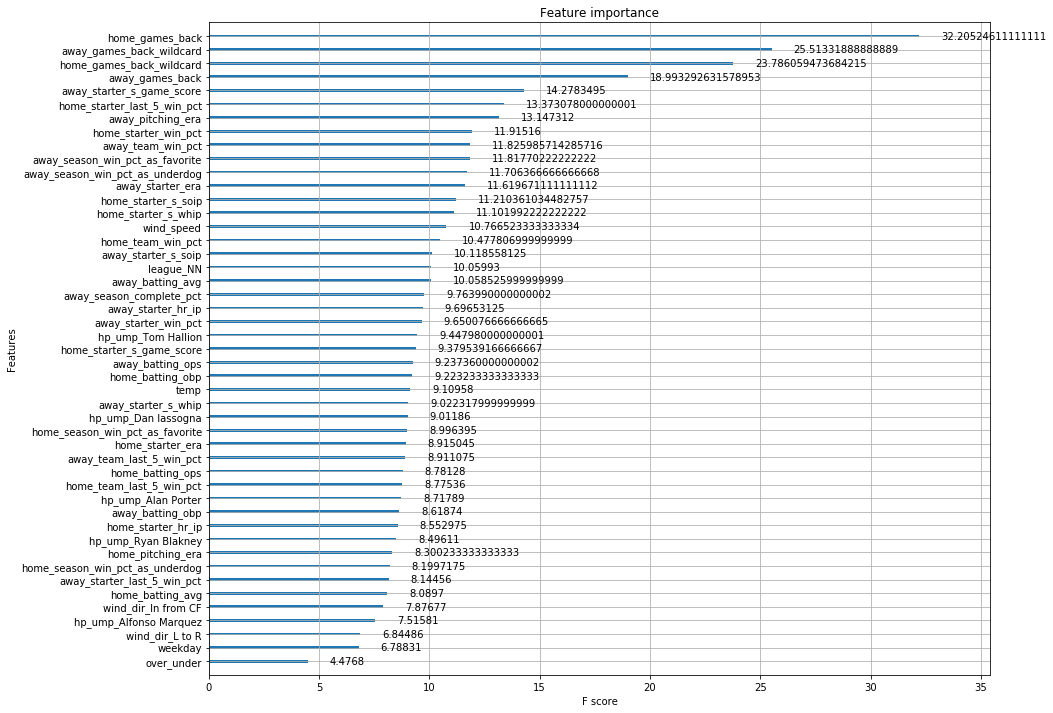

In [21]:
%matplotlib inline
pyplot.rcParams['figure.figsize'] = [14, 12]
xgb.plot_importance(bst, importance_type='gain')